## Question	3 [Bootstrapping,	25 Marks]

In [1]:
# Import library
library(ggplot2)
library(reshape2)
library(corrplot)

# Load data
data3.train <- read.csv('./Task1B_train.csv')
data3.test <- read.csv('./Task1B_test.csv')

In [2]:
# Create training and test subset
data3.train.data <- data3.train[, -5] # grab records, leave out the y (last column)
data3.train.label <- data3.train[, 5]
data3.test.data <- data3.test[, -5] # grab records, leave out the y (last column)
data3.test.label <- data3.test[, 5]

### I. Modify the code in Activity 2 to	handle bootstrapping for	KNN	regression.

In [3]:
# Define the average function for KNN regression

avg <- function(x) {
  round(mean(x),2)
}

# Refer to tutorial code 
# KNN function (Use euclidean distance here)
knn <- function(train.data, train.label, test.data, K=3){
  
  ## count number of train samples
  train.len <- nrow(train.data)
  
  ## count number of test samples
  test.len <- nrow(test.data)
  
  ## calculate distances between samples
  dist <- as.matrix(dist(rbind(test.data, train.data), method= 'euclidean'))[1:test.len, (test.len+1):(test.len+train.len)]
  
  ## for each test sample...
  for (i in 1:test.len){
    ### ...find its K nearest neighbours from training sampels...
    nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
    ###... and calculate the predicted labels according to the mean value of K neighbours
    data3.test.label[i]<- avg(train.label[nn])
  }
  
  ## return the class labels as output
  return (data3.test.label)
}

In [4]:
# Bootstrapping
# Define a function that generates sample indixes based on bootstrap technique
boot <- function (original.size, sample.size, times){
  indx <- matrix(nrow=times, ncol=sample.size)
  for (t in 1:times){
    indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
  }
  return(indx)
}

### II. Load Task1B_train.csv and Task1B_test.csv sets. Apply your bootstrapping for KNN regression with times = 100 (the number of subsets), size = 30 (the size of each subset), and change K=1,..,20 (the neighbourhood size). Now create a boxplot where the x-axis is K, and the y- axis is the average error (and the uncertainty around it) corresponding to each K. Save the plot in your Jupyter Notebook file for Question 3.

In [5]:
# fix the parameters (50,40,50)
K <- 20           # Maximum K for KNN 
L <- 100          # number of datasets
N <- 30          # size of datasets

In [6]:
# refer to tutorial code
# generate bootstrap indices:
boot.indx <- boot(nrow(data3.train.data), N, L)

# a dataframe to track the number of missclassified samples in each case
miss <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))

## for every k values:
for (k in 1: K){
  
  ### for every dataset sizes:
  for (l in 1:L){
    
    #### calculate iteration index i
    i <- (k-1)*L+l
    
    #### save sample indices that were selected by bootstrap
    indx <- boot.indx[l,]
    
    #### save the value of k and l
    miss[i,'K'] <- k
    miss[i,'L'] <- l
    
    #### calculate and record the train and test missclassification rates
    miss[i,'test'] <-  sum((knn(data3.train.data[indx, ], data3.train.label[indx], data3.test.data, K=k)-data3.test.label)^2)/nrow(data3.test.data)
  } 
}

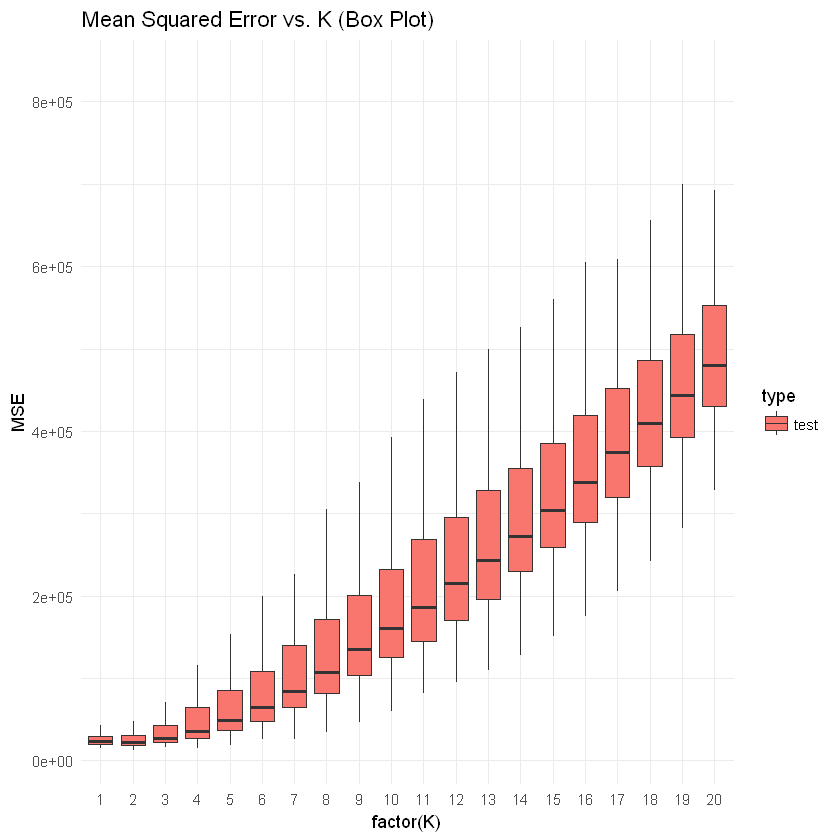

In [9]:
# boxplot
miss.m <- melt(miss, id=c('K', 'L')) # reshape for visualization
names(miss.m) <- c('K', 'L', 'type', 'MSE')
ggplot(data=miss.m[miss.m$type=='test',], aes(factor(K), MSE,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
  scale_color_discrete(guide = guide_legend(title = NULL)) + 
  ggtitle('Mean Squared Error vs. K (Box Plot)') + theme_minimal()
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

### III. Based on the plot in the previous part (Part I), how does the test error and its uncertainty behave as K increases? Explain in your Jupyter Notebook file.

#### Ans:

From the boxplot above, we can know the mean squared error is increasing when K is increasing, beacuse the model tends to be underfitting.

### IV. Load Task1B_train.csv and Task1B_test.csv sets. Apply your bootstrapping for KNN regression with K=10 (the neighbourhood size), size = 30 (the size of each subset), and change times = 10, 20, 30,.., 200 (the number of subsets). Now create a boxplot where the x-axis is ‘times’, and the y-axis is the average error (and the uncertainty around it) corresponding to each value of ‘times’. Save the plot in your Jupyter Notebook file for Question 3.

In [10]:
# set parameters
K <- 10                     # K for KNN 
L <- seq(10,200,10)         # number of datasets
N <- 30                     # size of datasets

# a dataframe to track the number of missclassified samples in each case

mse.L <- data.frame('times'=0, 'll'=0, 'test'=0)
for (ll in L){
  mse.L <- rbind(mse.L,data.frame('times'=ll,'ll'=1:ll,'test'=rep(0,ll)))
}
mse.L <- mse.L[c(2:nrow(mse.L)),]

# main loop
for (t in 1:length(L)){
  
  ll <- L[t]
  # generate bootstrap indices:
  boot.indx <- boot(nrow(data3.train.data), N, ll)
  
  for (l in 1:ll){
    
    #### calculate iteration index i
    i <- 5*t*(t-1)+l
    
    #### save sample indices that were selected by bootstrap
    indx <- boot.indx[l,]
    
    #### save the value of k and l
    mse.L[i,'times'] <- ll
    mse.L[i,'ll'] <- l
    
    #### calculate and record the train and test missclassification rates
    mse.L[i,'test'] <-  mean(sum((knn(data3.train.data[indx, ], data3.train.label[indx], data3.test.data, K=10)-data3.test.label)^2)/nrow(data3.test.data))
  }
}

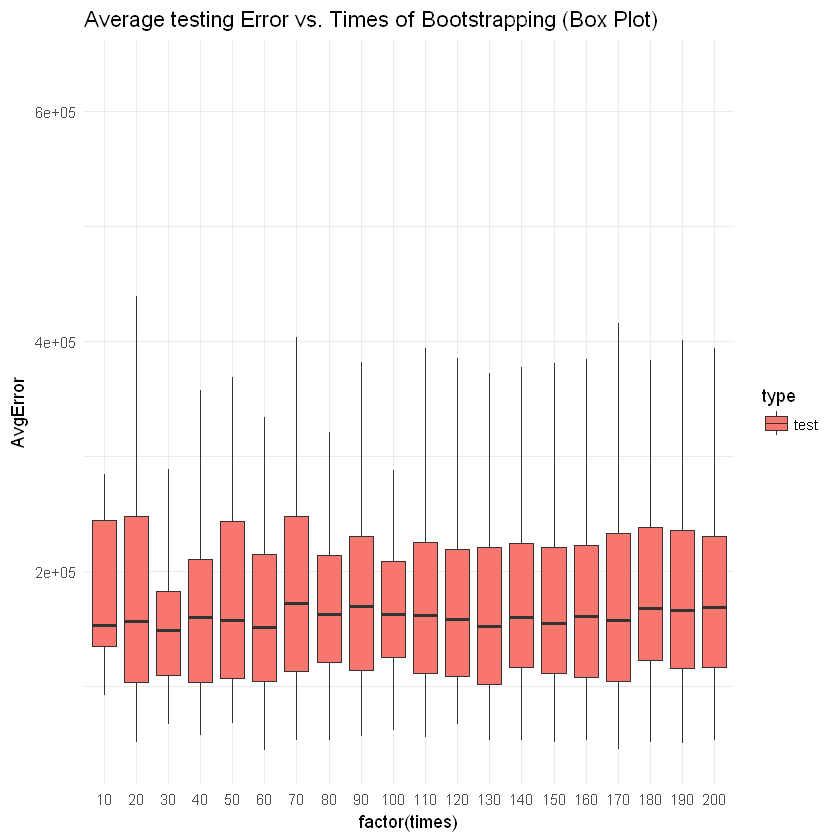

In [13]:
# boxplot
mse.L.m <- melt(mse.L, id=c('times', 'll')) # reshape for visualization
names(mse.L.m) <- c('times', 'll', 'type', 'AvgError')
ggplot(data=mse.L.m[mse.L.m$type=='test',], aes(factor(times), AvgError,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
  scale_color_discrete(guide = guide_legend(title = NULL)) + 
  ggtitle('Average testing Error vs. Times of Bootstrapping (Box Plot)') + theme_minimal()

### V. Based on the plot in the previous part (Part IV), how does the test error and its uncertainty behave as the number of subsets in bootstrapping increases? Explain in your Jupyter Notebook file.

#### Answear:
From the plot above, we can know that after the times of bootstraping reaches 80, the average testing error and the uncertainty tend to be stable. It means that increasing the time of bootstrapping does not always reduce the error of the model. After a certain number of times bootstrapping the error tends to be stable.